In [1]:
DATAPATH = ''
FILENAME = 'ultimate_data_challenge.json'

In [81]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from itertools import cycle, islice
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [8]:
with open(DATAPATH+FILENAME) as fi:
    nlines = 0
    for line in fi: nlines += 1
nlines

1

In [9]:
with open(DATAPATH+FILENAME) as fi:
    line = fi.readline()
    
    print(line[:60])
    print(line[-60:])

[{"city": "King's Landing", "trips_in_first_30_days": 4, "si
_pct": 0.0, "avg_dist": 3.49, "avg_rating_by_driver": 5.0}]



In [12]:
r = json.loads(line)
len(r)

50000

In [14]:
r[0].keys()

dict_keys(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

In [16]:
r[49999].keys()

dict_keys(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

In [18]:
df = pd.DataFrame(r)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
df.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


In [24]:
for c in df.columns:
    print(c, df[c].nunique())

avg_dist 2908
avg_rating_by_driver 27
avg_rating_of_driver 37
avg_surge 115
city 3
last_trip_date 182
phone 2
signup_date 31
surge_pct 367
trips_in_first_30_days 59
ultimate_black_user 2
weekday_pct 666


In [26]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [27]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

In [28]:
df['signup_date'] = pd.to_datetime(df.signup_date)

In [29]:
df.last_trip_date.min(), df.last_trip_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

In [30]:
df.signup_date.min(), df.signup_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-01-31 00:00:00'))

In [32]:
df.last_trip_date.value_counts()[:20]

2014-06-29    2036
2014-06-28    1679
2014-06-30    1408
2014-06-27    1120
2014-06-22    1024
2014-06-21     869
2014-01-19     848
2014-01-26     808
2014-06-26     793
2014-06-14     665
2014-06-15     647
2014-06-20     612
2014-06-25     603
2014-01-25     601
2014-01-12     586
2014-01-20     557
2014-07-01     548
2014-06-23     546
2014-01-18     542
2014-06-07     534
Name: last_trip_date, dtype: int64

In [34]:
df['target'] = 1*(df.last_trip_date > pd.Timestamp('2014-06-03'))
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,target
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [35]:
for c in df.columns:
    print(c, df[c].isnull().sum())

avg_dist 0
avg_rating_by_driver 201
avg_rating_of_driver 8122
avg_surge 0
city 0
last_trip_date 0
phone 396
signup_date 0
surge_pct 0
trips_in_first_30_days 0
ultimate_black_user 0
weekday_pct 0
target 0


In [52]:
df_30days = df[df.last_trip_date - df.signup_date > '30 days']

In [72]:
X = df_30days.drop(['last_trip_date', 'target', 'signup_date'], axis=1)

In [73]:
y = df_30days['target']

In [74]:
X.loc[X.phone.isnull(), 'phone'] = 'Unknown'

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
le = LabelEncoder()
X_train.loc[:,'phone'] = le.fit_transform(X_train.phone)
X_test.loc[:,'phone'] = le.transform(X_test.phone)
X_train.loc[:,'city'] = le.fit_transform(X_train.city)
X_test.loc[:,'city'] = le.transform(X_test.city)

In [88]:
d_train = lgb.Dataset(X_train, label=y_train)

In [164]:
params = {}
params['learning_rate'] = 0.05 # 0.004 # shrinkage_rate
params['sub_feature'] = 0.5    # feature_fraction (small values => use very different submodels)
#params['bagging_freq'] = 0
#params['bagging_fraction'] = .95
params['min_data'] = 100        # min_data_in_leaf
params['max_depth'] = 5

nboost=500



In [165]:
cv = lgb.cv(params, d_train, verbose_eval=50, metrics=['auc'], num_boost_round=500)

[50]	cv_agg's auc: 0.807367 + 0.0031322
[100]	cv_agg's auc: 0.811285 + 0.0032448
[150]	cv_agg's auc: 0.812252 + 0.00321749
[200]	cv_agg's auc: 0.813462 + 0.00315814
[250]	cv_agg's auc: 0.81394 + 0.00308853
[300]	cv_agg's auc: 0.814226 + 0.00324735
[350]	cv_agg's auc: 0.814391 + 0.00316485
[400]	cv_agg's auc: 0.814471 + 0.00321146
[450]	cv_agg's auc: 0.814384 + 0.00310811
[500]	cv_agg's auc: 0.814189 + 0.00304878


In [166]:
# 8144

In [167]:
clf = lgb.train(params, d_train, nboost)
pred = clf.predict(X_test)

In [168]:
pred

array([0.05421692, 0.68269211, 0.54554736, ..., 0.27955395, 0.6778408 ,
       0.02207382])

In [169]:
print( confusion_matrix(y_test, pred>.5) )

[[2805  933]
 [ 994 2663]]


In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

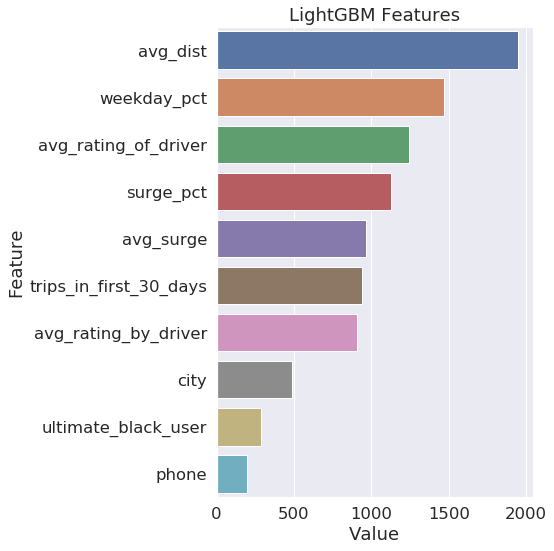

In [179]:
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(8, 8))
sns.set(font_scale = 1.5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()